跨品种套利又称配对交易，是利用相关但不同商品之间，在同一到期时间的期货合约上，利用价格差异进行交易的策略。

本篇文章主要从统计学角度对跨品种交易进行分析。

为了证明跨品种套利品种的可行性，首先要引入协整测试，Cointegration Test。

协整检验是一种统计方法，用于确定两个或多个时间序列是否相互存在长期关系。

它有助于识别变量是否在长期内一起移动。

在金融和经济分析中，协整在分析可能具有共同基础关系的成对或成组变量时尤其重要。协整测试时为了表明，虽然单个品种的时间序列可能具有趋势或非平稳性，但从长远来看，它们之间存在稳定的关系。

具体的检验过程涉及到计量经济学内的Engle-Granger检验或Johansen检验，这些留给感兴趣的朋友自行查阅。

幸运的是，python statsmodels 模块内有专门用于cointegration test工具，这给价差分析帮了大忙。

In [1]:
import rqdatac
import pandas as pd
import datetime as dt
import re
import seaborn
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import plotly.graph_objects as go

rqdatac.init() #初始化数据端口

In [2]:
all_instruments = rqdatac.all_instruments(type = "Future")
# 需要将数据保存到本地，请注销下列代码注释。
# all_instruments.to_csv("20230722_all_instruments.csv")

期货由于合约存续的问题，其指数可以被分成多种，例如主力连续合约，指数连续合约。
* 主力合约顾名思义，是由每个时间点的品种主力合约拼接而成。

下面摘录一段Rqdata官方对主力合约的定义。
  
主力连续合约是由该品种期货不同时期主力合约接续而成，代码以 88、888、889 结尾。
例如：
* IF88 为合约量价数据的简单拼接，未做平滑处理。
* IF888 为对价格进行了"前复权平滑"处理，处理规则如下：以主力合约切换前一天（T-1 日）新、旧两个主力合约收盘价做差，之后将 T-1 日及以前的主力连续合约的所有价格水平整体加上或减去该价差，以"整体抬升"或"整体下降"主力合约的价格水平，成交量、持仓量均不作调整，成交额统一设置为0.
*  IF889 为对价格进行“后复权平滑”处理，处理规则如下：以主力合约切换当天（T 日）旧、新两个主力合约开盘价做差， 之后将 T 日及以后的主力连续合约的所有价格水平整体加上或减去该价差，成交量、持仓量均不作调整，成交额统一设置为0.
* 指数连续合约：由当前品种全部可交易合约以累计持仓量为权重加权平均得到，代码以 99 结尾，例如 IF99。

本节价差分析会采用99结尾的指数连续合约，原因是每次主力合约换月产生的跳空影响对指数连续合约是最小的。  
考虑到分析所用的窗口期通常以年为单位，且每个品种换月的时间不一致，基差也影响程度也不一样。  
经过复权处理的主力连续合约在长期状况下有可能出现价格为负的情况。
因此综合考虑，采用指数连续合约作为分析对象。

In [3]:
def string2datetime(datetime:str):
    """string格式的日期转换成为datetime格式"""
    return dt.datetime.strptime(datetime, "%Y-%m-%d")

def filter_unlisted_futures(all_instruments: pd.DataFrame, commodity_index_order_book_id_list: list, start_date: str):
    """过滤从start_date起始，但还没上市的期货品种"""
    # 筛选出品种合约的基本信息，删除指数合约信息。
    contract_instruments = all_instruments[all_instruments["maturity_date"] != "0000-00-00"]
    # 将每个品种最早的期货合约可交易时间当作该品种的上市时间。 
    symbol_first_listed_date_df =  contract_instruments.drop_duplicates("underlying_symbol", keep="first")
    # 遍历每个品种首次合约上市的基本信息，用来和start_date作比较。
    for _, row in symbol_first_listed_date_df.iterrows():
        if string2datetime(row["listed_date"]) > string2datetime(start_date):
            try:
                commodity_index_order_book_id_list.remove(row["underlying_symbol"]+"99")
            except:
                print("error ecountered in filter unlisted futures function",row["underlying_symbol"])
    return commodity_index_order_book_id_list

def create_commodity_index_contract_info(all_instruments: pd.DataFrame, start_date: str, end_date:str):
    """
    手动生成期货品种指数信息表，
    用来配合本系列文章实践1中的 download_hist_data 函数。
    """
    # 以99结尾的交易代码是rqdata数据库的期货商品指数代码。
    mask_ends_with99 = all_instruments["order_book_id"].str.endswith("99")
    commodity_index_instruments = all_instruments[mask_ends_with99]
    commodity_index_order_book_id_list = commodity_index_instruments['order_book_id'].to_list()
    # 国内期货品种近年来上市提速，
    # 难免会出现在start_date之后才上市的期货品种，
    # 为了保证样本容量的数据量，
    # 这里对查询时间段start_date之后才上市的期货品种进行过滤舍去。 
    commodity_index_order_book_id_list = filter_unlisted_futures(all_instruments, 
                                                                 commodity_index_order_book_id_list,
                                                                 start_date)
    # 为了方便调用之前已经写好的函数，download_hist_data
    # 将start_date转换成listed_date, end_date转换成de_listed_date。
    listed_dates = [start_date] * len(commodity_index_order_book_id_list)
    de_listed_dates = [end_date] * len(commodity_index_order_book_id_list)
    contract_info = pd.DataFrame({
        "order_book_id": commodity_index_order_book_id_list,
        "listed_date":listed_dates, 
        "de_listed_date":de_listed_dates, 
    })
    
    return contract_info

In [4]:
start_date = "2017-1-1"
end_date = "2021-1-1"
index_contract_info = create_commodity_index_contract_info(all_instruments, start_date, end_date)
index_contract_info.head()

,order_book_id,listed_date,de_listed_date
0,A99,2017-1-1,2021-1-1
1,AG99,2017-1-1,2021-1-1
2,AL99,2017-1-1,2021-1-1
3,AU99,2017-1-1,2021-1-1
4,B99,2017-1-1,2021-1-1


In [5]:
print(index_contract_info["order_book_id"].to_list())

['A99', 'AG99', 'AL99', 'AU99', 'B99', 'BB99', 'BU99', 'C99', 'CF99', 'CS99', 'CU99', 'ER99', 'FB99', 'FG99', 'FU99', 'HC99', 'I99', 'IC99', 'IF99', 'IH99', 'J99', 'JD99', 'JM99', 'JR99', 'L99', 'LR99', 'M99', 'MA99', 'ME99', 'NI99', 'OI99', 'P99', 'PB99', 'PM99', 'PP99', 'RB99', 'RI99', 'RM99', 'RO99', 'RS99', 'RU99', 'S99', 'SF99', 'SM99', 'SN99', 'SR99', 'T99', 'TA99', 'TC99', 'TF99', 'V99', 'WH99', 'WR99', 'WS99', 'WT99', 'Y99', 'ZC99', 'ZN99']


下载这些数据之前，再手动清理一次不活跃的合约。

成交量不活跃的期货合约:BB 胶合板, CY 面纱, ER 早籼稻, FB 纤维板, JR 粳稻, LR 晚籼, ME 旧的甲醇代码, PM 普麦, RI 早籼, RO 旧的菜油交易代码, RR 粳米, RS 菜油籽, S(没找到), TC 旧的动力煤合约, WH 强麦, WR 线材, WS 旧的强麦, WT 旧的普麦, ZC 动力煤  

金融股指期货合约  
IF，IC，IH  

金融债券期货  
T，TS，TF  

一天成交量在5万手以下的次活跃期货  
CJ99， NR 20号胶， PB 铅，   

本次任务主要聚焦在商品期货的跨品种套利上，保守起见，故将上述提到的合约从之后的分析中剔除。  
后续有研究需求的话，请读者自行加入验证。

In [6]:
to_be_filtered_list = ["BB", "CY", "ER", "FB", "JR", "LR", "ME", "PM", "RI", "RO", "RR", "RS", "S", "TC", "WH", "WR", "WS", "WT", "ZC", "IF", "IC", "IH", "T", "TS", "TF", "CJ", "NR", "PB"]

In [7]:
filtered_index_contract_info = index_contract_info[~index_contract_info["order_book_id"].isin([i + "99" for i in to_be_filtered_list])]
filtered_index_contract_info.head()

,order_book_id,listed_date,de_listed_date
0,A99,2017-1-1,2021-1-1
1,AG99,2017-1-1,2021-1-1
2,AL99,2017-1-1,2021-1-1
3,AU99,2017-1-1,2021-1-1
4,B99,2017-1-1,2021-1-1


In [8]:
# 续用实践1中代码块
def download_hist_data(contract_info):
    """
    下载历史行情数据
    一次查询一个品种的所有合约
    """
    contracts_price = rqdatac.get_price(
        order_book_ids=contract_info["order_book_id"].to_list(),
        start_date=contract_info["listed_date"].values[0],
        end_date = contract_info["de_listed_date"].values[-1],
        frequency = "1d",
    )
    # 返回的历史数据有两个index，需要删去一个多余的order_book_id
    contracts_price.reset_index(level='order_book_id', inplace = True)
    # 按照时间顺序排序
    contracts_price.sort_index(inplace = True)

    return contracts_price


In [9]:
index_price = download_hist_data(filtered_index_contract_info)
# 对index重置，原本是以trade_date为index，为了方便后面的检测，需要生成以trade_date为index，品种名为列的表格。
index_price.reset_index(inplace = True)


In [10]:
# 将表格整理成以时间戳为索引，品种指数代码为列名，收盘价为内容的形式。
index_close_prices = pd.pivot_table(data=index_price, values = "close", columns="order_book_id", index = "date")
index_close_prices.head(2)

order_book_id,A99,AG99,AL99,AU99,B99,BU99,C99,CF99,CS99,CU99,...,RM99,RU99,SF99,SM99,SN99,SR99,TA99,V99,Y99,ZN99
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,4214.3671,4075.5793,12658.5847,269.8009,3980.0909,2649.4352,1526.9236,15101.7844,1796.0721,45781.6423,...,2278.3536,18389.5366,5150.8848,6548.2519,149524.3974,6802.2871,5442.8531,6015.7014,6959.0299,21026.8104
2017-01-04,4274.6426,4127.0712,12706.1725,270.4410,4135.5882,2655.7491,1540.5636,15102.0599,1817.8703,45560.1009,...,2308.4954,18559.2823,5182.7904,6518.2153,150205.2272,6865.5168,5383.4876,6125.8588,6892.2634,21174.3980


In [11]:
# 如果index_close_prices 内有空值，则舍去该行。
count_NAN = index_close_prices.isnull().sum().sum()
print(count_NAN)
if (count_NAN):
    index_close_prices.dropna(axis = 0, inplace=True)

11


In [12]:
def find_cointegrated_pairs(data):
    """
    生成critical value matrix, 
    pvalue_matrix, 
    以及返回p值小于0.1的交易对
    """
    N = data.shape[1]
    score_matrix = np.zeros((N, N))
    pvalue_matrix = np.ones((N, N))
    keys = data.keys()
    pairs = []
    for i in range(N):
        for j in range(i+1, N):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.1:
                pairs.append((keys[i], keys[j]))
    columns = index_close_prices.columns
    score_matrix = pd.DataFrame(score_matrix, columns = columns, index = columns)
    pvalue_matrix = pd.DataFrame(pvalue_matrix, columns = columns, index = columns)
    try:
        score_matrix.replace(0, np.nan, inplace = True)
        pvalue_matrix.replace(0, np.nan, inplace = True)
    except:
        pass
    return score_matrix, pvalue_matrix, pairs

In [13]:
score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(index_close_prices)

<AxesSubplot:xlabel='order_book_id', ylabel='order_book_id'>

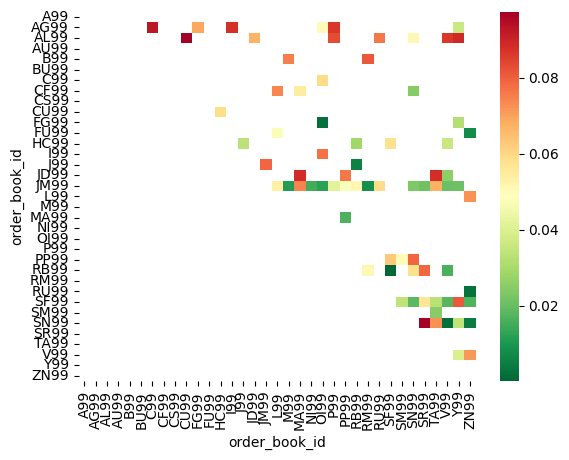

In [14]:
columns = index_close_prices.columns
seaborn.heatmap(pvalue_matrix, xticklabels=columns, yticklabels=columns,
                cmap='RdYlGn_r', mask = (pvalue_matrix >= 0.1))

In [15]:
pairs[:5]

[('AG99', 'C99'),
 ('AG99', 'FG99'),
 ('AG99', 'I99'),
 ('AG99', 'OI99'),
 ('AG99', 'P99')]

从图上可以看出被证明存在协整关系的trading pair数量并不少，但并不是每一对都能被当作跨品配对。  
因为该检测并不是完美的，可能会收到时间序列结构的变化，可能收到样本容量的问题，特别是针对不同商品分类的交易对，如果遇到跨大类的交易对也存在协整关系的话，需要特别注意。例如：AG99和C99，一个是黄金指数，一个是玉米指数，两者在行业上，产业链上，不管是替代性还是上下游链都不存在关联。  
因此，即使在数据上验证过协整性后，也还要根据基本面的情况，逐个排查可行性。

# 提示：
除上述出现在pairs列表中的交易对之外，还有一部分在产业上被认可，但是在cointegration test中被剔除的交易对。  
例如豆粕M和菜粕RM。

In [16]:
coint(index_close_prices["M99"], index_close_prices["RM99"])

(-2.298094829229688,
 0.374503833116418,
 array([-3.90786074, -3.34248883, -3.04886167]))

豆粕和菜粕在cointegrantion test中， pvalue只有0.37，远远高出原先设定的0.1 critical value。  
即从统计学角度，该交易对的价差值不具有稳定性。  
但是在现实交易中，协整标准不是判断交易对能否进行的唯一标准，协整测试也只是参考工具，具体上的落实也可以根据基本面的数据进行判断。  
另外，0.1 critical value也不是唯一的设定，具体大小可以根据交易员对产业链、基本面的经验进行调整。

In [17]:
# 举例选择HC99和RB99作为交易对
RB99 = index_close_prices["RB99"]
RB99 = sm.add_constant(RB99)
HC99 = index_close_prices["HC99"]
results = sm.OLS(HC99, RB99).fit()
results.params

const    86.788629
RB99      0.987565
dtype: float64

In [18]:
# 实际操作中，基本确定为1：1的关系
spread = HC99 - RB99["RB99"]
spread = spread.to_frame(name = "spread")

# 对具体月份合约画时序图和季节图

In [20]:
# 螺纹钢和热卷的秋季主力合约是10月
formula = "RB10 - HC10"
years_trace_back = 5
contract_instruments = all_instruments[all_instruments["listed_date"] != "0000-00-00"]
contract_symbol_list = re.findall(r'[A-Za-z]+\d+', formula)
contract_symbol_list

['RB10', 'HC10']

In [21]:
def get_contract_info_list_and_available_lookback_window_list(self, contract_symbol_list):
    contract_info_list = []
    available_lookback_window_list = []
    for i in contract_symbol_list:
        contract_info, available_lookback_window = self.get_contract_info(i,contract_instruments,years_trace_back)
        contract_info_list.append(contract_info)
        available_lookback_window_list.append(available_lookback_window)
    
    return contract_info_list, available_lookback_window_list

def get_contract_info(
                contract_from_formula: str, 
                instruments: pd.DataFrame,
                years_trace_back: int,
        ):
    """
    从交易代码和rqdata获取的all_instruments信息表中，
    获取相应的历史合约代码。
    例如已知MA09，要求获取过去N年的09合约代码，包括上市日期，退市日期。
    """
    underlying_symbol = re.findall(pattern = r"[A-Za-z]+", string = contract_from_formula)[0]
    instruments_copy = instruments.copy()
    # 创建新的列，存储合约的月份，该列的数据类型为2个字符串。
    instruments_copy.loc[:, "maturity_date_month"] = pd.to_datetime(instruments_copy["maturity_date"]).dt.month.astype(str).str.zfill(2)
    # 创建新的列，存储合约的年份，该列的数据类型为4个字符串。
    instruments_copy.loc[:, "maturity_date_year"] = pd.to_datetime(instruments_copy["maturity_date"]).dt.year.astype(str).str.zfill(4)
    # mask1，mask2为两个筛选器。
    # mask1 筛选期货品种
    mask1 = instruments_copy["underlying_symbol"] == underlying_symbol
    # mask2 筛选合约月份
    mask2 = instruments_copy["maturity_date_month"] == contract_from_formula[-2:]
    instruments_copy = instruments_copy[mask1 & mask2]
    # 筛选出过去最新N年的期货合约， N由years_trace_back决定。
    instruments_copy = instruments_copy.iloc[-years_trace_back:, :]

    print(f"{len(instruments_copy)} years of symbol {contract_from_formula} historical contracts are found.")
    return (instruments_copy[["order_book_id", "listed_date", "de_listed_date","maturity_date_year"]], len(instruments_copy))

def create_figure(data: pd.DataFrame):
    fig = go.Figure()
    x = data.index
    # 根据 列名 遍历传入的数据表
    for label, content in data.items():
        fig.add_trace(
            go.Scatter(
                x = x, 
                y = content, 
                mode = "lines",
                name = label,
                connectgaps = True,
                showlegend=True
            )
        )
    # 显示10个标签
    tickvals = list(range(0, len(x), int(len(x) / 10)))
    ticktext = [x[i] for i in tickvals]
    # 设置layout
    fig.update_layout(
        xaxis_title = "X轴",
        yaxis_title = "Y轴",
        yaxis = dict(
            showgrid = True,zeroline = True,showline = True,gridcolor = "#eee",linecolor = "#444"
        ),
        xaxis = dict(
            type = "category",categoryarray = x,showgrid = True,zeroline = True,gridcolor = "#eee",linecolor = "#444",tickvals = tickvals,ticktext = ticktext,
        ),
        legend = dict(
            orientation = "h",x = 0.25,y = 1.15,xanchor = "left",yanchor = "top",traceorder = "normal",font = dict(
                family = "Arial",size = 12,color = "black"
            ),
            bgcolor = "rgba(0,0,0,0)",bordercolor = "rgba(0,0,0,0)"
        ),
        plot_bgcolor = "white"
    )

    return fig

In [22]:
contract_info_list = []
# available_trace_back_window 可以查询到的回溯年限。
available_lookback_window_list = []
for i in contract_symbol_list:
    contract_info, available_lookback_window = get_contract_info(i,contract_instruments,years_trace_back)
    contract_info_list.append(contract_info)
    available_lookback_window_list.append(available_lookback_window)


5 years of symbol RB10 historical contracts are found.
5 years of symbol HC10 historical contracts are found.


In [26]:
# 对获得的各品种信息进行矫正。
# 价差计算经常会遇到不同品种合约，上市时间不一样的情形。
# 例如（在rqdata上）螺纹钢最长能查询到15年的历史，铁矿最长只能查询到10年的历史，
# 如果要查询最长时间，做价差计算时，螺纹钢和铁矿必须在时间戳上进行对齐。
# 这也就意味着，螺纹钢比铁矿早期的五年历史行情是需要舍去的。
lookback_window_for_spread = min(available_lookback_window_list)
if lookback_window_for_spread < years_trace_back:
    print(f"only {lookback_window_for_spread} years data is available for spread calculation.")
    for num in range(len(contract_info_list)):
        contract_info_list[num] = contract_info_list[num].tail(lookback_window_for_spread)
# contract_info_list, available_lookback_window_list
# 该块代码将被命名为trading_period_alignment, 存放到class SpreadCalculation中。

In [24]:
spread = pd.DataFrame(columns = ["spread"])
# 以循环方式逐个下载历史价格，这样代码可以接收2个以上的品种作价差
for i, j in zip(contract_symbol_list, contract_info_list):
    print(i)
    exec(f"{i} = download_hist_data(j)['close']")
exec(f"spread['spread'] = {formula}")
spread.dropna(axis = 0, inplace = True)
spread.index = pd.to_datetime(spread.index)
spread.head()

RB10
HC10


,spread
date,
2018-10-16,37.0
2018-10-17,56.0
2018-10-18,62.0
2018-10-19,39.0
2018-10-22,67.0


In [25]:
unsplited_data = spread.copy()
unsplited_data.index = unsplited_data.index.date
fig = create_figure(data = unsplited_data)
fig.show()

In [27]:
def find_contract_month_as_int(contract: str):
    """
    根据合约名称如'MA05'返回最后两位数字，
    即返回合约的月份
    """
    return int(re.findall("\d{2}$", contract)[0])

In [28]:
contract_month_list = []
for i in contract_symbol_list:
    month = find_contract_month_as_int(i)
    contract_month_list.append(month)

contract_month_list

[10, 10]

In [29]:
def find_arbitrage_period_mask(contract_month_list: list):
    """
    返回筛选套利组合可交易时间段的筛选器
    """
    min_month = min(contract_month_list)
    max_month = max(contract_month_list)
    delta = max_month - min_month
    if (delta <= 6):
        end = dt.date(2000, min_month, 1)
        start = dt.date(2000, max_month, 1)
        return lambda x: [y.month < end.month or y.month > start.month for y in x]
    
    else:
        start = dt.date(2000, min_month, 1)
        end = dt.date(2000, max_month, 1)
        return lambda x: [y.month > start.month and y.month < end.month for y in x]


In [30]:
# 由于RB10-HC10都是10月到期的合约，在这里除了10月份之外，其余时间都是可交易时间段。
spread = spread[find_arbitrage_period_mask(contract_month_list)(spread.index)]

In [31]:
def split_by_year(spread: pd.DataFrame):
    """
    上述产生的spread包含了年份信息，但是画季节图是根据每年的月份、日子时间将价差行情重复画在一张图上。
    这里需要对数据进行操作，将单列的spread行情，根据月份、日子拆分成多列。
    """
    splited_data = pd.DataFrame(index=pd.date_range(start='2000-01-01', end='2000-12-31', freq='D').strftime("%m-%d"))
    for year in spread.index.year.unique():
        year_data = spread[spread.index.year == year]
        # 从索引日期中删除年份
        year_data.index = year_data.index.strftime("%m-%d")
        # 将年度数据添加为split_data DataFrame中的新列
        splited_data[year] = year_data
    return splited_data

In [32]:
splited_spread_data = split_by_year(spread).copy()
#splited_spread_data.dropna(axis = 0, thresh=1, inplace = True)
fig = create_figure(data = splited_spread_data)
fig.show()

# Summary


本文主要分成两个部分，第一部分对各商品期货之间进行了cointegration test，包括品种的筛选，期货指数历史行情下载，数据清理，协整模型验证等。

第二部分对已经验证部分的RB和HC举例画图，并升级重写了实践1中的代码，使画图程序能够满足2个以上的品种计算，且能够满足公式内出现系数相乘的条件。实践1中的代码只能是"A-B"，升级后可实现"A-2*B", "A-2*B-C"的计算公式。

以下对画图部分的代码重新编辑修改，重写class SpreaedCalculation, 以备长期使用。

In [56]:
# 将本格代码另存到一个.py文件，并命名成spread_analysis.py

import re 
import rqdatac
import pandas as pd
import datetime as dt
rqdatac.init()
import plotly.graph_objects as go

class SpreadCalculation:
    """
    
    """
    def __init__(self, formula, years_trace_back, trade_period_filter = False) -> None:
        self.formula = formula
        self.years_trace_back = years_trace_back
        # 可以通过访问rqdatac接口来获取期货合约基本信息，也可以通过读取保存好的文件，这里采用后者。
        # self.all_instruments = rqdatac.all_instruments(type = "Future")
        # 筛选除去连续合约、主力合约代码。
        # self.all_instruments = self.all_instruments[self.all_instruments["maturity_date"] != "0000-00-00"] 
        self.all_instruments = pd.read_csv("20230722_all_instruments.csv", index_col = 0)
        self.spread = pd.DataFrame()
        self.trade_period_filter = trade_period_filter
        self.get_contract_instruments()
        self.get_index_instruments()
    def get_contract_instruments(self):
        """
        返回合约信息，不包括指数类信息
        """
        all_instruments = self.all_instruments
        contract_instruments = all_instruments[all_instruments["listed_date"] != "0000-00-00"].copy()
        self.contract_instruments = contract_instruments
        
    
    def get_index_instruments(self):
        """ 
        返回指数类信息，不包括合约信息
        """
        all_instruments = self.all_instruments
        index_instruments = all_instruments[all_instruments["listed_date"] == "0000-00-00"].copy()
        self.index_instruments = index_instruments
    
    def get_contract_info(
        self,
        contract_from_formula: str, # e.g. MA09
        ):
        """ 
        从交易代码和rqdata获取的all_instruments信息表中，
        获取相应的历史合约代码。
        例如已知MA09，要求获取过去N年的09合约代码，包括上市日期，退市日期。
        """
        underlying_symbol = re.findall(pattern = r"[A-Za-z]+", string = contract_from_formula)[0]
        contract_instruments = self.contract_instruments
        # 创建新的列，存储合约的月份，该列的数据类型为2个字符串。
        contract_instruments.loc[:, "maturity_date_month"] = pd.to_datetime(contract_instruments["maturity_date"]).dt.month.astype(str).str.zfill(2)
        # 创建新的列，存储合约的年份，该列的数据类型为4个字符串。
        contract_instruments.loc[:, "maturity_date_year"] = pd.to_datetime(contract_instruments["maturity_date"]).dt.year.astype(str).str.zfill(4)
        # mask1，mask2为两个筛选器。
        # mask1 筛选期货品种
        mask1 = contract_instruments["underlying_symbol"] == underlying_symbol
        # mask2 筛选合约月份
        # 注意不能有空格
        mask2 = contract_instruments["maturity_date_month"] == contract_from_formula[-2:]
        contract_instruments = contract_instruments[mask1 & mask2]
        # 筛选出过去最新N年的期货合约， N由years_trace_back决定。
        contract_instruments = contract_instruments.iloc[-self.years_trace_back:, :]
        print(f"{len(contract_instruments)} years of symbol {contract_from_formula} historical contracts are found.")
        return (contract_instruments[["order_book_id", "listed_date", "de_listed_date","maturity_date_year"]], len(contract_instruments))

    def download_hist_data(self, contract_info):
        contracts_price = rqdatac.get_price(
            order_book_ids=contract_info["order_book_id"].to_list(),
            start_date=contract_info["listed_date"].values[0],
            end_date = contract_info["de_listed_date"].values[-1],
            frequency = "1d",
        )
        # rqdatac返回的历史数据有两个index，需要删去一个多余的order_book_id
        contracts_price.reset_index(level='order_book_id', inplace = True)
        # 按照时间顺序排序
        contracts_price.sort_index(inplace = True)

        return contracts_price

    def split_by_year(self):
        # Convert the index to datetime if it is not already in datetime format
        
        # Create an empty DataFrame with the date range as the index
        splited_data = pd.DataFrame(index=pd.date_range(start='2000-01-01', end='2000-12-31', freq='D').strftime("%m-%d"))
        for year in self.spread.index.year.unique():
            year_data = self.spread[self.spread.index.year == year]
            # Remove the year from the index date
            year_data.index = year_data.index.strftime("%m-%d")
            # Add the year's data as a new column in the split_data DataFrame
            splited_data[year] = year_data

        return splited_data

    def create_figure(self, data):
        fig = go.Figure()
        x = data.index
        # 根据 列名 遍历传入的数据表
        for label, content in data.items():
            fig.add_trace(
                go.Scatter(
                    x = x, 
                    y = content, 
                    mode = "lines",
                    name = label,
                    connectgaps = True,
                    showlegend = True
                )
            )
        # 显示10个标签
        tickvals = list(range(0, len(x), int(len(x) / 10)))
        ticktext = [x[i] for i in tickvals]
        # 设置layout
        fig.update_layout(
            xaxis_title = "X轴",
            yaxis_title = "Y轴",
            yaxis = dict(
                showgrid = True,
                zeroline = True,
                showline = True,
                gridcolor = "#eee",
                linecolor = "#444"
            ),
            xaxis = dict(
                type = "category",
                categoryarray = x,
                showgrid = True,
                zeroline = True,
                gridcolor = "#eee",
                linecolor = "#444",
                tickvals = tickvals,
                ticktext = ticktext,
            ),
            legend = dict(
                orientation = "h",
                x = 0.25,
                y = 1.15,
                xanchor = "left",
                yanchor = "top",
                traceorder = "normal",
                font = dict(
                    family = "Arial",
                    size = 12,
                    color = "black"
                ),
                bgcolor = "rgba(0,0,0,0)",
                bordercolor = "rgba(0,0,0,0)"
            ),
            plot_bgcolor = "white"
        )

        return fig
    
    def find_contract_month_as_int(self, contract: str):
        """
        根据合约名称如'MA05'返回最后两位数字，
        即返回合约的月份
        """
        return int(re.findall("\d{2}$", contract)[0])
    
    def get_contract_month_list(self, contract_symbol_list):
        """
        遍历合约名称列表
        根据合约名称如'MA05'返回最后两位数字，
        即返回合约的月份
        """
        contract_month_list = []
        for i in contract_symbol_list:
            month = int(re.findall("\d{2}$", i)[0])
            contract_month_list.append(month)
        return contract_month_list
    
    def find_arbitrage_period_mask(self, contract_month_list: list):
        """
        返回筛选套利组合可交易时间段的筛选器
        """
        min_month = min(contract_month_list)
        max_month = max(contract_month_list)
        delta = max_month - min_month
        if (delta <= 6):
            end = dt.date(2000, min_month, 1)
            start = dt.date(2000, max_month, 1)
            return lambda x: [y.month < end.month or y.month > start.month for y in x]
        
        else:
            start = dt.date(2000, min_month, 1)
            end = dt.date(2000, max_month, 1)
            return lambda x: [y.month > start.month and y.month < end.month for y in x]
        
    def get_contract_info_list_and_available_lookback_window_list(self, contract_symbol_list):
        contract_info_list = []
        available_lookback_window_list = []
        for i in contract_symbol_list:
            contract_info, available_lookback_window = self.get_contract_info(i)
            contract_info_list.append(contract_info)
            available_lookback_window_list.append(available_lookback_window)
    
        return contract_info_list, available_lookback_window_list

    def lookback_window_alignment(self, contract_info_list, available_lookback_window_list):
        """ 
        对获得的各品种年限进行矫正。
        价差计算经常会遇到不同品种合约，上市时间不一样的情形。
        例如（在rqdata上）螺纹钢最长能查询到15年的历史，铁矿最长只能查询到10年的历史，
        当用到这两者做价差计算时，螺纹钢和铁矿必须在时间戳上进行对齐。
        这也就意味着，螺纹钢比铁矿早五年的历史行情需要舍去的。
        """
        lookback_window_for_spread = min(available_lookback_window_list)
        if lookback_window_for_spread < self.years_trace_back:
            print(f"only {lookback_window_for_spread} years data is available for spread calculation.")
            for num in range(len(contract_info_list)):
                contract_info_list[num] = contract_info_list[num].tail(lookback_window_for_spread)       
        
        return contract_info_list
    
    def clean_symbol_list(self, contract_symbol_list):
        new_list = []
        for i in contract_symbol_list:
            new_list.append(i.strip())
        return new_list
    
    def calculate_spread(self, ):

        #contract_symbol_list = re.split(pattern = r'[\+\-\*\/]', string = self.formula)
        contract_symbol_list = re.findall(r"[A-Za-z]+\d+", self.formula)
        # 情理合约符号，不能带空格
        #contract_symbol_list = self.clean_symbol_list(contract_symbol_list)
        contract_info_list, available_lookback_window_list = self.get_contract_info_list_and_available_lookback_window_list(contract_symbol_list)
        # 对获得的各品种信息进行矫正。
        # 价差计算经常会遇到不同品种合约，上市时间不一样的情形。
        # 例如（在rqdata上）螺纹钢最长能查询到15年的历史，铁矿最长只能查询到10年的历史，
        # 当用到这两者做价差计算时，螺纹钢和铁矿必须在时间戳上进行对齐。
        # 这也就意味着，螺纹钢比铁矿早期的五年历史行情是需要舍去的。
        contract_info_list = self.lookback_window_alignment(contract_info_list, available_lookback_window_list)
        spread = pd.DataFrame(columns = ["spread"])
        for i, j in zip(contract_symbol_list, contract_info_list):
            print("downloading historical data for ", i)
            exec(f"{i} = self.download_hist_data(j)['close']")
        exec(f"spread['spread'] = {self.formula}")
        spread.dropna(axis = 0, inplace = True)
        spread.index = pd.to_datetime(spread.index)
        contract_month_list = self.get_contract_month_list(contract_symbol_list)
        mask_for_trade_period = self.find_arbitrage_period_mask(contract_month_list)(spread.index)
        # trade_period_filer 是一个开关，如果是True，季节图上仅展示个人交易者可交易日期
        # 否则展示季节图上展示价差全年日期行情
        if self.trade_period_filter:
            self.spread = spread.loc[mask_for_trade_period, :].copy()
        else:
            self.spread = spread.copy()
        # self.fig = self.create_figure(data = splited_spread_data)
        
    def plot_spread_with_year(self):

        unsplited_data = self.spread.copy()
        unsplited_data.index = unsplited_data.index.date
        self.fig = self.create_figure(data = unsplited_data)
        self.fig.show()

    def plot_spread_with_monthday(self):
        splited_spread_data = self.split_by_year().copy()
        # 删除没有任何数据的日期，否则画图时会出现大量的空白。
        splited_spread_data.dropna(axis = 0, thresh=1, inplace = True)
        # print(num_of_columns, splited_spread_data)
        self.fig = self.create_figure(data = splited_spread_data)
        self.fig.show()




c:\veighna_studio\lib\site-packages\rqdatac\client.py:202: UserWarning:

rqdatac is already inited. Settings will be changed.



In [57]:
import spread_analysis as sa

In [59]:
import spread_analysis as sa
import importlib
importlib.reload(sa)

formula = "RB10 -HC10"
years_trace_back = 5
RB10_HC10 = sa.SpreadCalculation(formula, years_trace_back)
RB10_HC10.calculate_spread()

c:\veighna_studio\lib\site-packages\rqdatac\client.py:202: UserWarning:

rqdatac is already inited. Settings will be changed.



5 years of symbol RB10 historical contracts are found.
5 years of symbol HC10 historical contracts are found.
RB10
HC10


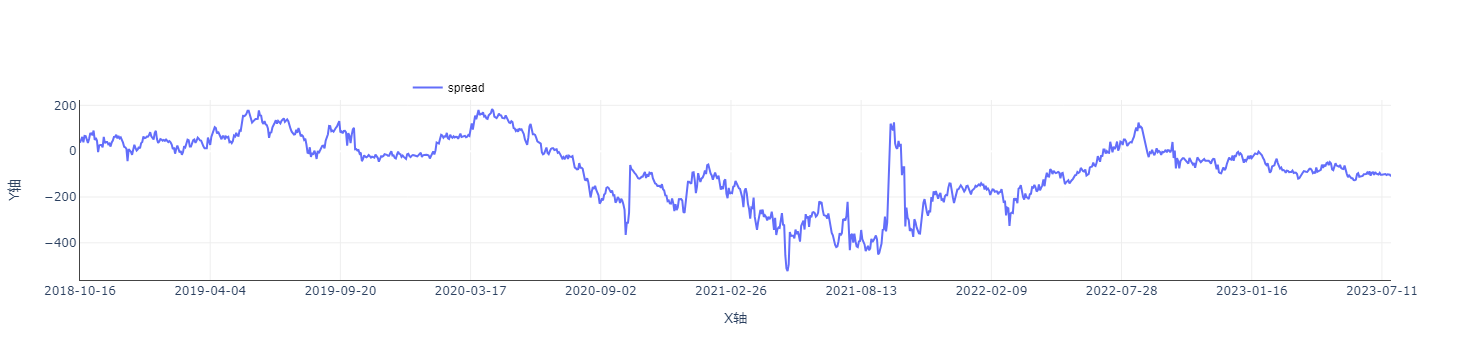

In [60]:
RB10_HC10.plot_spread_with_year()


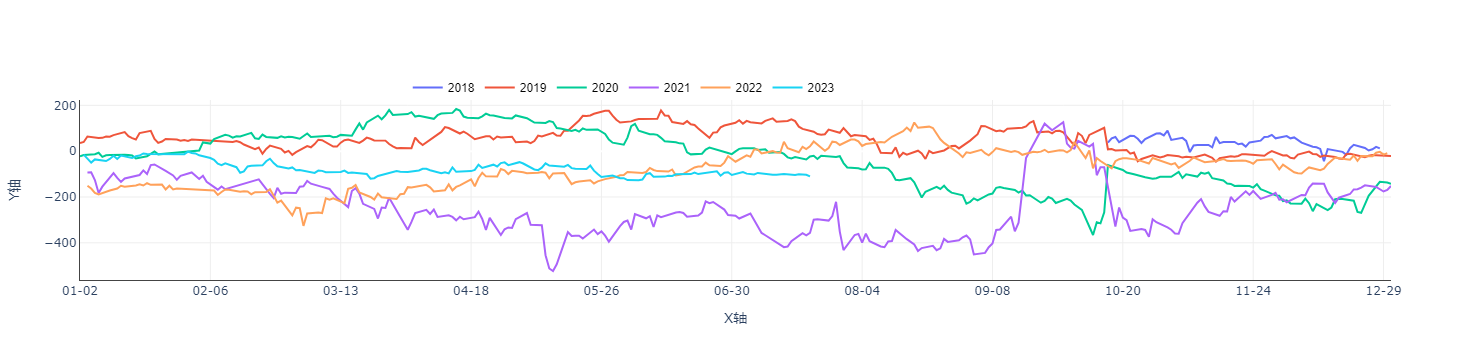

In [62]:
RB10_HC10.plot_spread_with_monthday()